GUIA PASO A PASO de Analysis exploratorio de datos:

Paso 1: Con nuestro set de datos nos preguntamos como influyen las variables a nuestro target,
en este caso, como influyen las variables numericas y categoricas al precio por habitacion.

Paso 2: Nos haremos una idea general de las caracteristicas de las variables del set de datos.

Paso 3: Definir los tipos de datos que tenemos.

Paso 4: Tipo de estadistiva descriptiva.

Paso 5: Visualizacion, mediante graficos de nuestras variables. tanto discretas como continuas.

Paso 6: Compararemos variables y buscaremos las interacciones entre ellas.

Paso 7: Extraeremos conclusiones.


In [26]:
#Primero de todo vamos a importar las librerias necesarias para realizar el EDA de
#Airbnb nova york
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import f_classif, SelectKBest
from pickle import dump


In [27]:

#Cargamos el csv via URL o pathing de nuestro repositorio
#y lo guardamos en una variable tipo dataframe
df_rawdata = pd.DataFrame(pd.read_csv("/workspaces/JBGEDA1/data/raw/AB_NYC_2019.csv"))

In [28]:
#Creamos una variable para que contenga una tupla, para saber
#las dimensiones de nuestro dataframe
dimensions = df_rawdata.shape
#El .info() nos dara informacion basica de nuestro dataframe
df_rawdata.info()
print("dimensions")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

Hacemos un breve analisis de nuestros datos (variables) por columnas.


In [29]:
#Eliminamos las columnas que no nos interese para correlacionar
#con nuestra variable target
df_rawdata.drop(['name','host_name','id', 'host_id',], inplace=True, axis=1)
#Podemos calcular la cantidad de nulls por columna, es decir datos
#erróneos o no insertados al indice
nulls = df_rawdata.isnull().sum()
#Printeamos nulls por consola
print(nulls)

neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64


NUESTRO TARGET , evidentemente sera el PRECIO DE ALQUILER POR HABITACIONES de las viviendas de airbnb en Nueva York. Por lo cual, ['name','host_name','id', 'host_id'] no nos interesa hacer una correlacion con dichas columnas.
Por la cantidad de nulls que hay en ['last_review'] y ['reviews_per_month''] tendremos que rellenar en reviews per month con una media y last review creo que sera irrelevante para correlacionar y realizar un modelo predictivo.

In [30]:
#Volvemos a eliminar columnas del DF.
df_rawdata.drop(['last_review'], inplace=True, axis=1)
#Para Visualizar que se ha eliminado
#podemos printear de nuevo el null
nulls = df_rawdata.isnull().sum()
#Printeamos nulls por consola
print(nulls)
df_rawdata.head(4)

neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64


,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.21,6,365
1,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355
2,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,1,365
3,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,1,194


Paso 1: Con nuestro set de datos nos preguntamos como influyen las variables a nuestro target,
en este caso, como influyen las variables numericas y categoricas al precio por habitacion.





Vayamos directos al paso 2 (idea general de las variables)
y Paso 3(Definir tipos de datos que tenemos)
PASO 2 Y PASO 3:

In [ ]:
#Realizaremos un info para ver ciertas cualidades de las columnas y ver que se han eliminado algunas.
df_rawdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   neighbourhood_group             48895 non-null  object 
 1   neighbourhood                   48895 non-null  object 
 2   latitude                        48895 non-null  float64
 3   longitude                       48895 non-null  float64
 4   room_type                       48895 non-null  object 
 5   price                           48895 non-null  int64  
 6   minimum_nights                  48895 non-null  int64  
 7   number_of_reviews               48895 non-null  int64  
 8   reviews_per_month               38843 non-null  float64
 9   calculated_host_listings_count  48895 non-null  int64  
 10  availability_365                48895 non-null  int64  
dtypes: float64(3), int64(5), object(3)
memory usage: 4.1+ MB


In [ ]:
#La columna de reviews_per_month sera importante, vamos a cambiar sus valores NA, por la media
df_rawdata['reviews_per_month'] = df_rawdata['reviews_per_month'].fillna(df_rawdata['reviews_per_month'].mean())
df_rawdata.head(4)
#Nos aseguramos que los datos de NA en ['reviews_per_month'] se han modificado.
'''
Observando el dataset de forma general, nos hacemos una idea de las principales variables que afectan
al precio:
-Numero minimo de noches de estancia, ['minimum_nights'] , variable numerica.
-Tipo de alquiler, habitacion o inmueble completo ['room_type'], variable categórica.
-['number_of_reviews'], variable numerica.
-['reviews_per_month'], variable numerica
-POR QUESTIONES DE UBICACIÓN TENEMOS VARIAS VARIABLES:
    -['neighbourhood_group'], variable categórica
    -['neighbourhood'], variable categórica
    -['latitude'], variable numerica
    -['Longitud'], variable numerica
    
    
    '''

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.210000,6,365
1,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.380000,2,355
2,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,1.373221,1,365
3,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,4.640000,1,194


PASO 4 y 5.
EMPEZAREMOS A VISUALIZAR NUESTRAS VARIABLES CATEGORICAS Y OBSERVAR COMO SE AGRUPAN SUS DATOS.
A priori solo tenemos 3 columnas categoricas. ['room_types'], ['neighbourhood'] y ['neighbourhood_group'].

<Axes: xlabel='room_type', ylabel='count'>

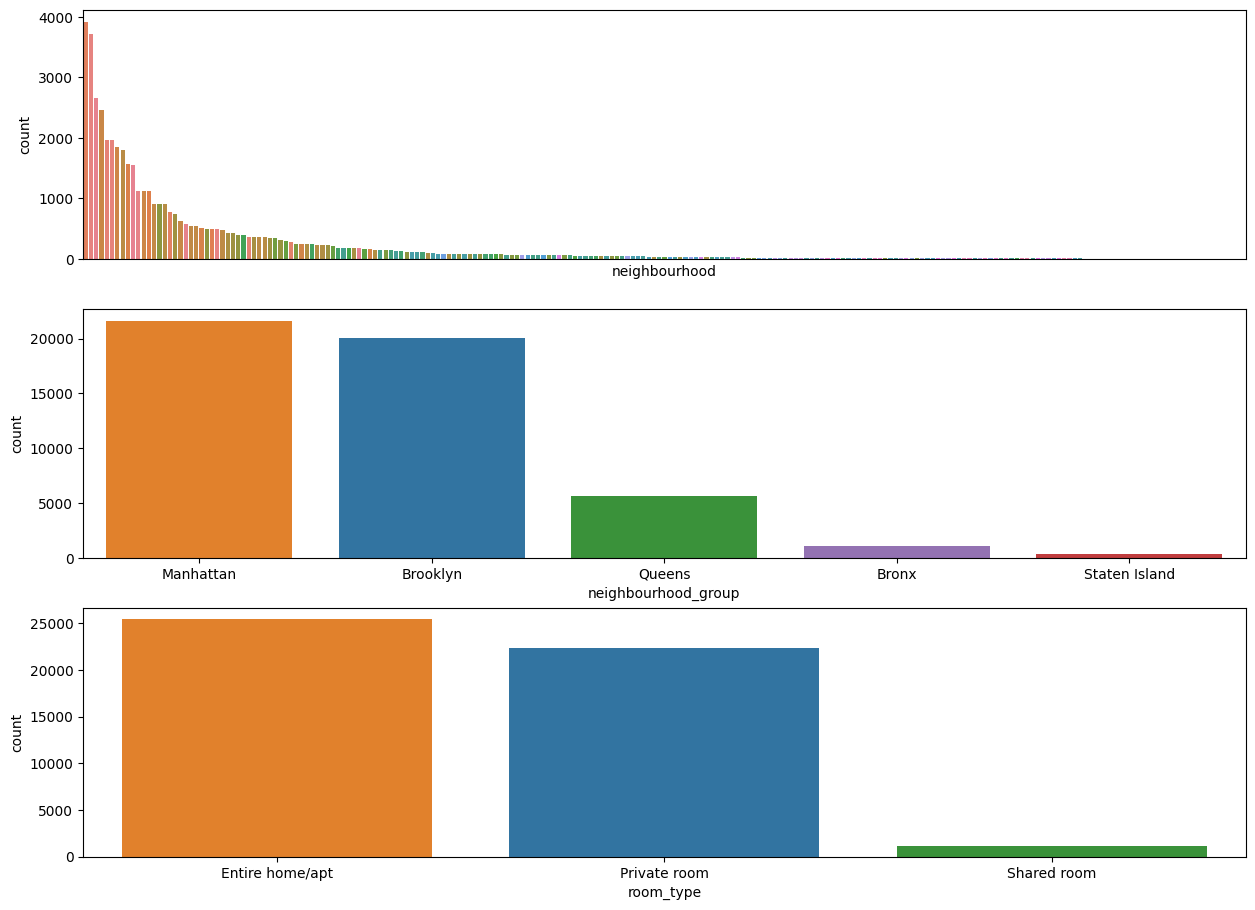

In [ ]:
fig, axis = plt.subplots(3, 1, figsize = (15, 11))
#Creamos 3 subgraficos en el conjunto,['room_types'], ['neighbourhood'] y ['neighbourhood_group'], analizando la cantidad de veces que aparece
#una variable categorica y sacar conclusiones. Es decir el eje Y de cada subplot sera la cantidad y el 
#eje x seran los valores categoricos de una columna, ordenandolo por orden de aparicion en el indice.
sns.countplot(ax = axis[0],
                data = df_rawdata,
                    x = "neighbourhood",
                        hue = "neighbourhood",
                            order=df_rawdata['neighbourhood'].sort_values().value_counts().index).set_xticks([])
#Con .set_xticks([]) suprimimos la aparicion descriptiva para cada punto de X.

sns.countplot(ax = axis[1],
                data = df_rawdata,
                    x = "neighbourhood_group",
                        hue = "neighbourhood_group",
                            order=df_rawdata['neighbourhood_group'].sort_values().value_counts().index)

sns.countplot(ax = axis[2],
                data = df_rawdata, 
                    x = "room_type",
                        hue = "room_type",
                            order=df_rawdata['room_type'].sort_values().value_counts().index)